In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_excel('/content/Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [3]:
# Define Mean Absolute Percentage Error Function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = np.where(y_true != 0)[0]  # Avoid division by zero
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100


In [4]:
# Data Preprocessing
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.sort_values('InvoiceDate', inplace=True)
data['TotalSales'] = data['Quantity'] * data['UnitPrice']
daily_sales = data.groupby(data['InvoiceDate'].dt.date)['TotalSales'].sum()

# Data Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler.fit_transform(daily_sales.values.reshape(-1, 1))

# Split Data into Training and Testing Sets
train_size = int(len(scaled_sales) * 0.8)
test_size = len(scaled_sales) - train_size
train, test = scaled_sales[0:train_size, :], scaled_sales[train_size:len(scaled_sales), :]


In [6]:
import numpy as np

# Convert Array of Values into a Dataset Matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back=1)
testX, testY = create_dataset(test, look_back=1)

# Reshape Data for LSTM Model
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape, trainY.shape)
look_back = 1  # This can be changed based on your specific time series data


(242, 1, 1) (242,)


In [8]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.5 MB/s eta 0:00:00


Reloading Tuner from my_dir/lstm_hyperopt/tuner0.json
2/2 [==============================] - 0s 6ms/step
LSTM Test Score: 51031.59 RMSE
LSTM Test Score: 47721.22 MAE
LSTM Test Score: 95.19 MAPE


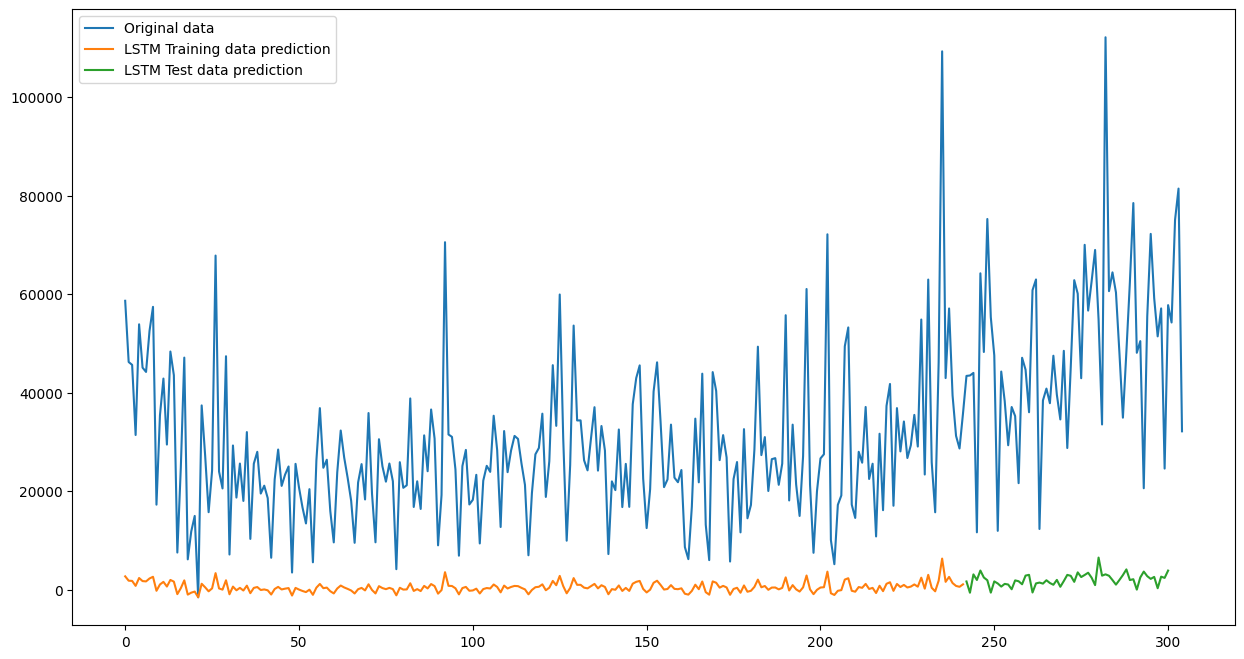

In [10]:
import numpy as np
from keras.layers import Dropout
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from sklearn.metrics import mean_squared_error, mean_absolute_error

# LSTM Hyperparameter Tuning
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                       input_shape=self.input_shape))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

hypermodel = LSTMHyperModel(input_shape=(1, look_back))
tuner = RandomSearch(hypermodel, objective='val_loss', max_trials=10, executions_per_trial=2,
                     directory='my_dir', project_name='lstm_hyperopt')
tuner.search(trainX, trainY, epochs=10, validation_split=0.2, verbose=2)

# Retrieve and Evaluate the Best LSTM Model
best_model = tuner.get_best_models(num_models=1)[0]
best_trainPredict = best_model.predict(trainX)
best_testPredict = best_model.predict(testX)
best_trainPredict = scaler.inverse_transform(best_trainPredict)
best_testPredict = scaler.inverse_transform(best_testPredict)

# LSTM Model with Dropout
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Predictions and Evaluation for LSTM Model
lstm_trainPredict = model.predict(trainX)
lstm_testPredict = model.predict(testX)
lstm_trainPredict = scaler.inverse_transform(lstm_trainPredict)
lstm_testPredict = scaler.inverse_transform(lstm_testPredict)
actual_trainY = scaler.inverse_transform([trainY])
actual_testY = scaler.inverse_transform([testY])

# LSTM Model Performance Metrics
lstm_trainScore = np.sqrt(mean_squared_error(actual_trainY[0], lstm_trainPredict[:,0]))
lstm_testScore = np.sqrt(mean_squared_error(actual_testY[0], lstm_testPredict[:,0]))
lstm_mae = mean_absolute_error(actual_testY[0], lstm_testPredict[:,0])
lstm_mape = mean_absolute_percentage_error(actual_testY[0], lstm_testPredict[:,0])

print('LSTM Test Score: %.2f RMSE' % (lstm_testScore))
print('LSTM Test Score: %.2f MAE' % (lstm_mae))
print('LSTM Test Score: %.2f MAPE' % (lstm_mape))

# Plotting Predictions for LSTM Model
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(scaled_sales), label='Original data')
plt.plot(lstm_trainPredict, label='LSTM Training data prediction')
plt.plot(np.arange(len(lstm_trainPredict), len(lstm_trainPredict) + len(lstm_testPredict)), lstm_testPredict, label='LSTM Test data prediction')
plt.legend(loc='best')
plt.show()

Trial 10 Complete [00h 00m 01s]

Best val_loss So Far: 0.026562229730188847
Total elapsed time: 00h 01m 30s
Epoch 1/50
8/8 - 5s - loss: 0.0366 - 5s/epoch - 682ms/step
Epoch 2/50
8/8 - 0s - loss: 0.0209 - 386ms/epoch - 48ms/step
Epoch 3/50
8/8 - 0s - loss: 0.0178 - 408ms/epoch - 51ms/step
Epoch 4/50
8/8 - 0s - loss: 0.0152 - 381ms/epoch - 48ms/step
Epoch 5/50
8/8 - 0s - loss: 0.0151 - 393ms/epoch - 49ms/step
Epoch 6/50
8/8 - 0s - loss: 0.0150 - 383ms/epoch - 48ms/step
Epoch 7/50
8/8 - 0s - loss: 0.0150 - 405ms/epoch - 51ms/step
Epoch 8/50
8/8 - 0s - loss: 0.0149 - 394ms/epoch - 49ms/step
Epoch 9/50
8/8 - 0s - loss: 0.0149 - 392ms/epoch - 49ms/step
Epoch 10/50
8/8 - 0s - loss: 0.0149 - 397ms/epoch - 50ms/step
Epoch 11/50
8/8 - 0s - loss: 0.0151 - 390ms/epoch - 49ms/step
Epoch 12/50
8/8 - 0s - loss: 0.0150 - 387ms/epoch - 48ms/step
Epoch 13/50
8/8 - 0s - loss: 0.0149 - 401ms/epoch - 50ms/step
Epoch 14/50
8/8 - 0s - loss: 0.0148 - 381ms/epoch - 48ms/step
Epoch 15/50
8/8 - 0s - loss: 0.0150

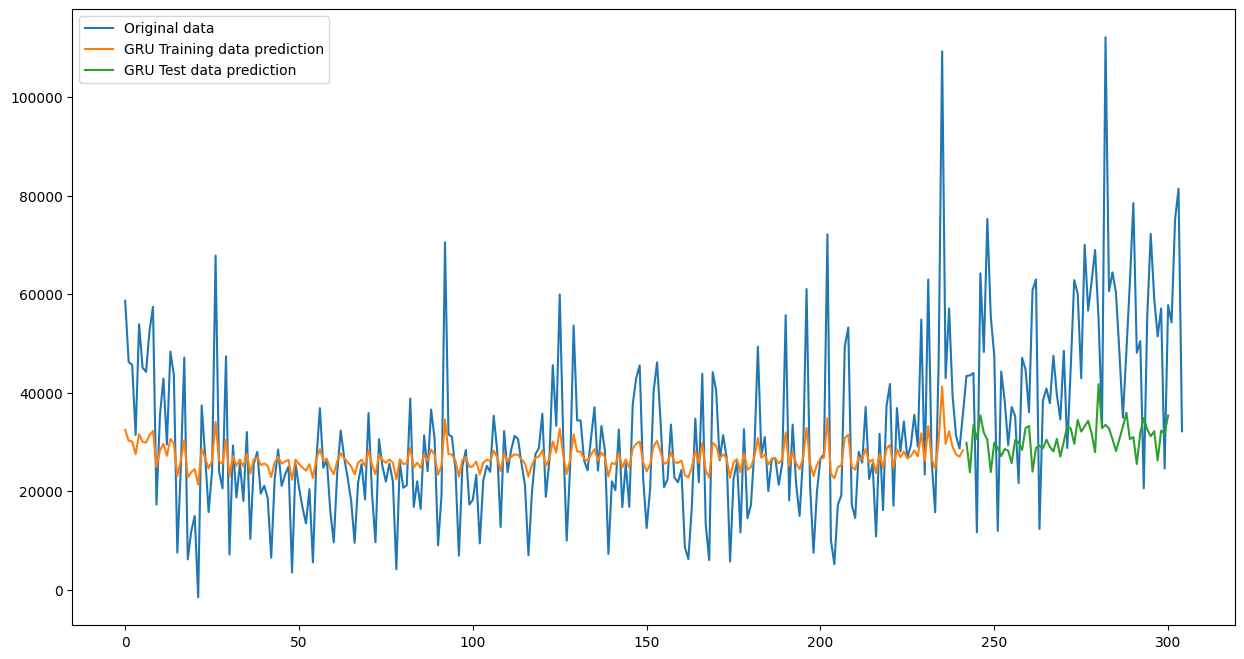

In [11]:
from keras.layers import GRU
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from sklearn.metrics import mean_squared_error, mean_absolute_error

# GRU Model Definition and Hyperparameter Tuning
class GRUHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(GRU(units=hp.Int('units', min_value=32, max_value=512, step=32),
                      input_shape=self.input_shape,
                      return_sequences=hp.Boolean('return_sequences')))
        if hp.Boolean('second_gru_layer'):
            model.add(GRU(units=hp.Int('units', min_value=32, max_value=512, step=32)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

gru_hypermodel = GRUHyperModel(input_shape=(1, look_back))
gru_tuner = RandomSearch(
    gru_hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='gru_hyperopt'
)
gru_tuner.search(trainX, trainY, epochs=10, validation_split=0.2, verbose=2)

# GRU Model Training and Evaluation
gru_model = Sequential()
gru_model.add(GRU(units=1000, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
gru_model.add(GRU(units=50))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(trainX, trainY, epochs=50, batch_size=32, verbose=2)

# Predictions and Evaluation for GRU Model
trainPredict = gru_model.predict(trainX)
testPredict = gru_model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
actual_trainY = scaler.inverse_transform([trainY])
actual_testY = scaler.inverse_transform([testY])

gru_trainScore = np.sqrt(mean_squared_error(actual_trainY[0], trainPredict[:,0]))
gru_testScore = np.sqrt(mean_squared_error(actual_testY[0], testPredict[:,0]))
gru_mae = mean_absolute_error(actual_testY[0], testPredict[:,0])
gru_mape = mean_absolute_percentage_error(actual_testY[0], testPredict[:,0])

print('GRU Test Score: %.2f RMSE' % (gru_testScore))
print('GRU Test Score: %.2f MAE' % (gru_mae))
print('GRU Test Score: %.2f MAPE' % (gru_mape))

# Plot Training and Test Predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(scaled_sales), label='Original data')
plt.plot(trainPredict, label='GRU Training data prediction')
plt.plot(np.arange(len(trainPredict), len(trainPredict) + len(testPredict)), testPredict, label='GRU Test data prediction')
plt.legend(loc='best')
plt.show()

Trial 10 Complete [00h 00m 37s]
val_loss: 0.02809102926403284

Best val_loss So Far: 0.02673379983752966
Total elapsed time: 00h 05m 49s
Epoch 1/50
8/8 - 7s - loss: 0.0705 - 7s/epoch - 923ms/step
Epoch 2/50
8/8 - 0s - loss: 0.0480 - 87ms/epoch - 11ms/step
Epoch 3/50
8/8 - 0s - loss: 0.0275 - 78ms/epoch - 10ms/step
Epoch 4/50
8/8 - 0s - loss: 0.0169 - 83ms/epoch - 10ms/step
Epoch 5/50
8/8 - 0s - loss: 0.0166 - 84ms/epoch - 11ms/step
Epoch 6/50
8/8 - 0s - loss: 0.0159 - 89ms/epoch - 11ms/step
Epoch 7/50
8/8 - 0s - loss: 0.0150 - 86ms/epoch - 11ms/step
Epoch 8/50
8/8 - 0s - loss: 0.0150 - 87ms/epoch - 11ms/step
Epoch 9/50
8/8 - 0s - loss: 0.0149 - 84ms/epoch - 10ms/step
Epoch 10/50
8/8 - 0s - loss: 0.0149 - 93ms/epoch - 12ms/step
Epoch 11/50
8/8 - 0s - loss: 0.0149 - 98ms/epoch - 12ms/step
Epoch 12/50
8/8 - 0s - loss: 0.0148 - 91ms/epoch - 11ms/step
Epoch 13/50
8/8 - 0s - loss: 0.0149 - 84ms/epoch - 11ms/step
Epoch 14/50
8/8 - 0s - loss: 0.0148 - 81ms/epoch - 10ms/step
Epoch 15/50
8/8 - 0

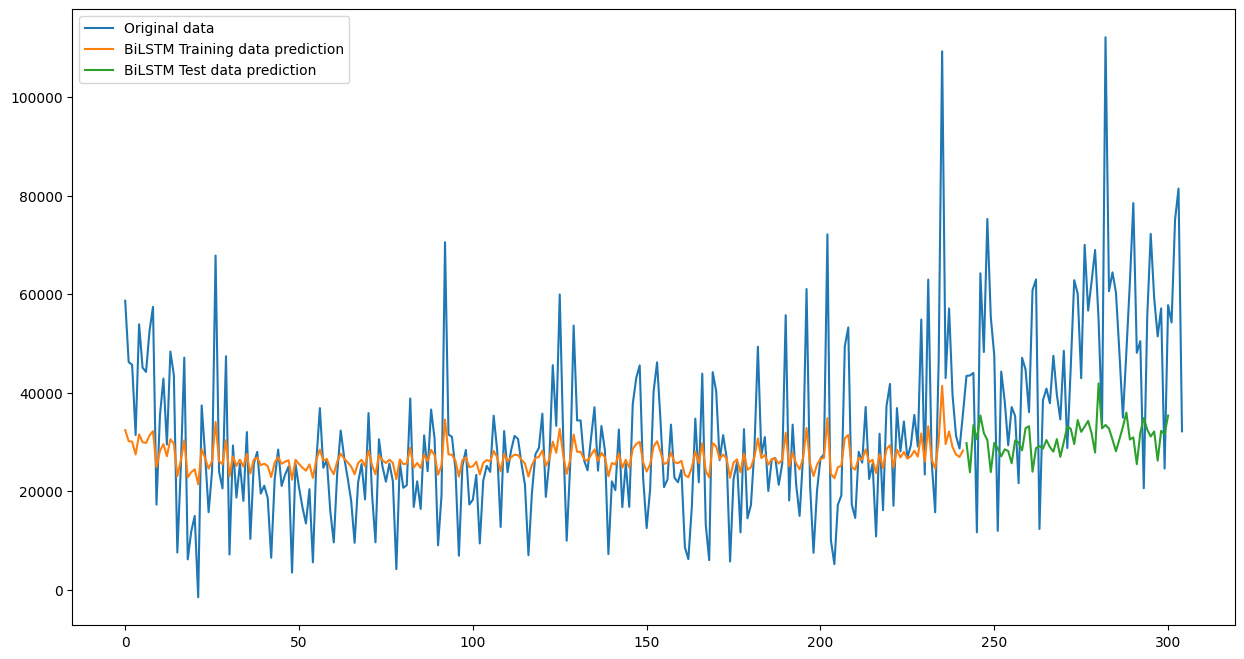

In [12]:
from keras.layers import Bidirectional
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from sklearn.metrics import mean_squared_error, mean_absolute_error

# BiLSTM Model Definition and Hyperparameter Tuning
class BiLSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                                    return_sequences=True),
                                input_shape=self.input_shape))
        model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32))))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

bilstm_hypermodel = BiLSTMHyperModel(input_shape=(trainX.shape[1], trainX.shape[2]))
bilstm_tuner = RandomSearch(
    bilstm_hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='bilstm_hyperopt'
)
bilstm_tuner.search(trainX, trainY, epochs=10, validation_split=0.2, verbose=2)

# BiLSTM Model Training and Evaluation
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(trainX.shape[1], trainX.shape[2])))
bilstm_model.add(Bidirectional(LSTM(units=50)))
bilstm_model.add(Dense(1))
bilstm_model.compile(optimizer='adam', loss='mean_squared_error')
bilstm_model.fit(trainX, trainY, epochs=50, batch_size=32, verbose=2)

# Predictions and Evaluation for BiLSTM Model
bilstm_trainPredict = bilstm_model.predict(trainX)
bilstm_testPredict = bilstm_model.predict(testX)
bilstm_trainPredict = scaler.inverse_transform(bilstm_trainPredict)
bilstm_testPredict = scaler.inverse_transform(bilstm_testPredict)
bilstm_trainScore = np.sqrt(mean_squared_error(actual_trainY[0], bilstm_trainPredict[:,0]))
bilstm_testScore = np.sqrt(mean_squared_error(actual_testY[0], bilstm_testPredict[:,0]))
bilstm_mae = mean_absolute_error(actual_testY[0], bilstm_testPredict[:,0])
bilstm_mape = mean_absolute_percentage_error(actual_testY[0], bilstm_testPredict[:,0])

print('BiLSTM Test Score: %.2f RMSE' % (bilstm_testScore))
print('BiLSTM Test Score: %.2f MAE' % (bilstm_mae))
print('BiLSTM Test Score: %.2f MAPE' % (bilstm_mape))

# Plotting Predictions for BiLSTM Model
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(scaled_sales), label='Original data')
plt.plot(bilstm_trainPredict, label='BiLSTM Training data prediction')
plt.plot(np.arange(len(bilstm_trainPredict), len(bilstm_trainPredict) + len(bilstm_testPredict)), bilstm_testPredict, label='BiLSTM Test data prediction')
plt.legend(loc='best')
plt.show()

# **To forecast which consumers are most likely to make a purchase in the upcoming month**

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
from sklearn.impute import SimpleImputer

# Load the data
data = pd.read_excel('/content/Online Retail.xlsx')

# Convert 'InvoiceDate' to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Define churn period (e.g., 6 months)
churn_period = timedelta(days=180)
latest_date = data['InvoiceDate'].max()

# Calculate last purchase date for each customer
last_purchase = data.groupby('CustomerID')['InvoiceDate'].max()

# Determine if a customer has churned
churn = (latest_date - last_purchase) > churn_period
churn_df = churn.rename('Churn').reset_index()

# Merge churn information back to the original DataFrame
data = pd.merge(data, churn_df, on='CustomerID', how='left')

# Fill NaN values in Churn column with 0 (assuming new customers)
data['Churn'] = data['Churn'].fillna(0).astype(int)

# Encode categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['InvoiceNo', 'StockCode', 'Description', 'Country']
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col].astype(str))

# Extract time components from 'InvoiceDate'
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['Day'] = data['InvoiceDate'].dt.day
data['Weekday'] = data['InvoiceDate'].dt.weekday

# Drop the original 'InvoiceDate' column
data.drop('InvoiceDate', axis=1, inplace=True)

# Prepare data for logistic regression
X = data.drop('Churn', axis=1)
y = data['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop rows with NaN values
X_train_dropped = X_train.dropna()
y_train_dropped = y_train[X_train_dropped.index]

# Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_dropped, y_train_dropped)

# Prepare the test set similarly (ensure the indices match)
X_test_dropped = X_test.dropna()
y_test_dropped = y_test[X_test_dropped.index]

# Evaluate the model
accuracy = model.score(X_test_dropped, y_test_dropped)
print('Model Accuracy:', accuracy)


Model Accuracy: 0.9467628201183869


In [26]:
print(data.columns)

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice',
       'CustomerID', 'Country', 'Churn', 'Year', 'Month', 'Day', 'Weekday'],
      dtype='object')


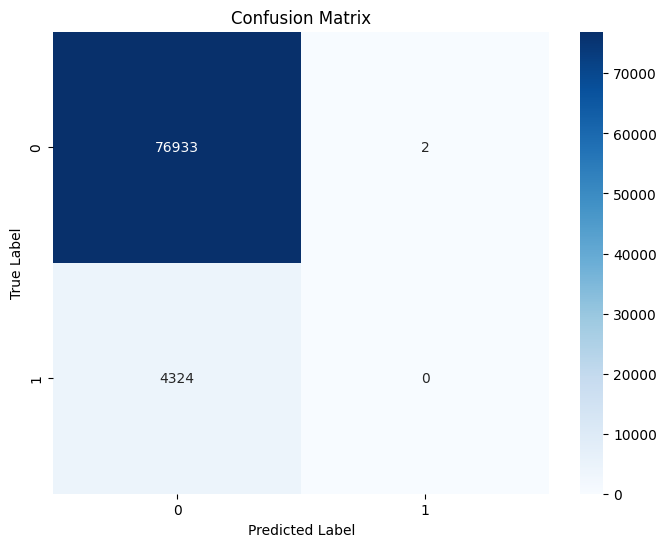

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predictions on the test set
y_pred = model.predict(X_test_dropped)

# Compute confusion matrix
cm = confusion_matrix(y_test_dropped, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


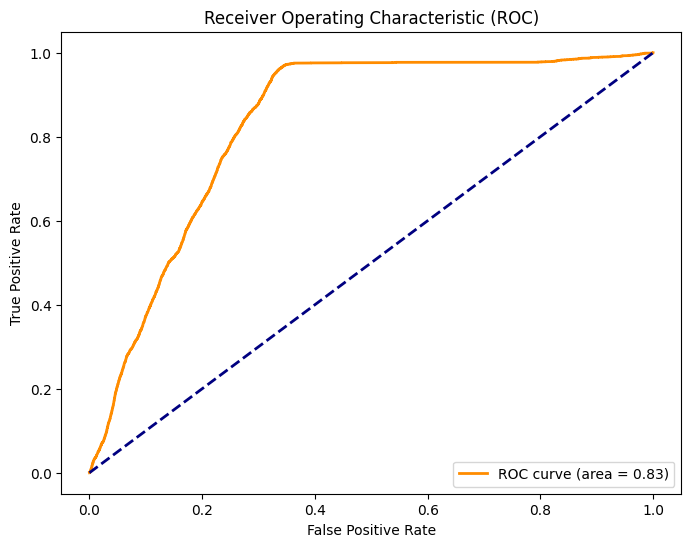

In [30]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test_dropped, model.predict_proba(X_test_dropped)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
